In [1]:
import numpy as np
from scipy import signal
from scipy.io.wavfile import read
from IPython.display import Audio
import matplotlib.pyplot as plt
from numpy.fft import fft

In [2]:
def downsample_4k(data, fs):
    resamp_len = (4000 * data.shape[0]) // fs
    return signal.resample(data, resamp_len)

def bandpass(data):
    b = signal.firls(25, [0, 250, 300, 2000], [0, 0, 1, 1], fs=4000)
    w, h = signal.freqz(b)
    plt.plot(w, 20*np.log10(abs(h)))
    return signal.lfilter(b, 1, data)

def stft(data, win_len=100, win_overlap=10):
    frame_start = 0
    
    win_len_frames = 4000 * win_len // 1000
    win_overlap_frames = 4000 * win_overlap // 1000
    
    num_frames = data.shape[0] // win_overlap_frames
    print(data.shape)
    print(num_frames)

    stft_out = np.zeros((num_frames, win_len_frames//2))
    frame = np.zeros(win_len_frames)
    fft_frame = np.zeros(win_len_frames)
    
    for i in range(num_frames):
        frame_start = i * win_overlap_frames
        win = np.hamming(win_len_frames)
        if frame_start + win_len_frames >= data.shape[0]:
            frame[0:data.shape[0]-frame_start] = data[frame_start:]
            frame = frame * win
        else:
            frame = win * data[frame_start : frame_start + win_len_frames]
        fft_frame = abs(fft(frame))
        stft_out[i,:] = np.square(np.abs(fft_frame[:win_len_frames//2])) / win_len_frames
            
    return stft_out

def compute_mel(data, nbins=18):
    low_mfreq = 0
    hi_mfreq = 2595 * np.log10(1 + 2000/700)
    m_points = np.linspace(low_mfreq, hi_mfreq, nbins + 2)
    hz_points = (700 * (10**(m_points / 2595) - 1))
    
    bin = (4000*100//1000 + 1) * hz_points / 4000
    f_bank = np.zeros((nbins, 4000*100//1000 // 2))
    
    for m in range(1, nbins + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            f_bank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            f_bank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
            
    f_bank = np.where(f_bank < 0, 0, f_bank)

    filter_banks = np.dot(data, f_bank.T)
    filter_banks = np.where(filter_banks <= 0, np.finfo(float).eps, filter_banks)
    return 20 * np.log10(filter_banks)

def find_peaks(data):
    print(data.shape)

In [3]:
fs, data = read('test_audio.wav')
if (data.shape[1] != 1):
    data = data[:,0]

(981916,)
(81826,)


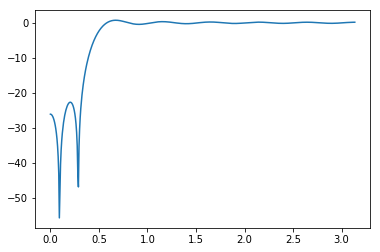

In [4]:
# apply downsampling
data_2 = downsample_4k(data, fs)
print(data.shape)
print(data_2.shape)

# apply bandpass
data_3 = bandpass(data_2)

(81826,)
2045


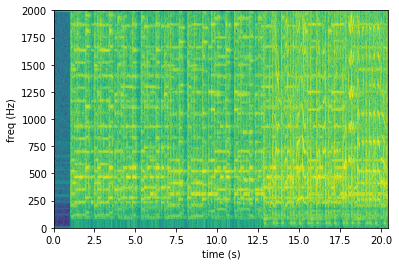

In [5]:
# compute stft

stft_out = stft(data_3)

scales = [np.linspace(0, data_3.size/4000, stft_out.shape[0]+1), np.linspace(0, 4000/2, stft_out.shape[1]+1)]

plt.figure()
plt.pcolormesh(scales[0], scales[1], 20*np.log10(stft_out.T))
plt.xlabel('time (s)')
plt.ylabel('freq (Hz)')
plt.axis('tight')
plt.show()

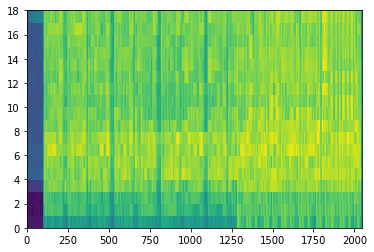

In [6]:
# apply mel filter bank

mels = compute_mel(stft_out)
plt.pcolormesh(mels.T)
plt.show()